## Import

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder
# from sklearn.feature_selection import RFE
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, mean_absolute_error, r2_score
from scipy.sparse import hstack, csr_matrix

# Models
from sklearn.tree import DecisionTreeClassifier
# from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
df = pd.read_csv("./fake reviews dataset.csv")
df

,category,rating,label,text_
0,Home_and_Kitchen_5,5.0,CG,"Love this! Well made, sturdy, and very comfor..."
1,Home_and_Kitchen_5,5.0,CG,"love it, a great upgrade from the original. I..."
2,Home_and_Kitchen_5,5.0,CG,This pillow saved my back. I love the look and...
3,Home_and_Kitchen_5,1.0,CG,"Missing information on how to use it, but it i..."
4,Home_and_Kitchen_5,5.0,CG,Very nice set. Good quality. We have had the s...
...,...,...,...,...
40427,Clothing_Shoes_and_Jewelry_5,4.0,OR,I had read some reviews saying that this bra r...
40428,Clothing_Shoes_and_Jewelry_5,5.0,CG,I wasn't sure exactly what it would be. It is ...
40429,Clothing_Shoes_and_Jewelry_5,2.0,OR,"You can wear the hood by itself, wear it with ..."
40430,Clothing_Shoes_and_Jewelry_5,1.0,CG,I liked nothing about this dress. The only rea...


In [ ]:
df.isnull().sum()

,0
category,0
rating,0
label,0
text_,0


# Visualization Functions

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import roc_curve, auc, confusion_matrix

def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10,7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

def plot_roc_curve(y_true, y_pred_proba, model_name):
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(10,7))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.7f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) Curve - {model_name}')
    plt.legend(loc="lower right")
    plt.show()

def plot_feature_importance(model, feature_names, tfidf_vectorizer, top_n=20):
    importances = model.feature_importances_

    tfidf_feature_names = ["[word]"+word for word in tfidf_vectorizer.get_feature_names_out()]
    other_feature_names = [name for name in feature_names]

    feature_importance = list(zip(tfidf_feature_names, importances[:len(tfidf_feature_names)]))
    feature_importance += list(zip(other_feature_names, importances[len(tfidf_feature_names):]))

    feature_importance.sort(key=lambda x: x[1], reverse=True)

    top_features = feature_importance[:top_n]

    plt.figure(figsize=(12,8))
    plt.title(f"Top {top_n} Feature Importances")
    plt.bar(range(top_n), [imp for name, imp in top_features])
    plt.xticks(range(top_n), [name for name, imp in top_features], rotation=90)
    plt.tight_layout()
    plt.show()
def plot_predicted_vs_actual(y_true, y_pred, model_name):
    plt.figure(figsize=(10,7))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--', lw=2)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'Predicted vs Actual - {model_name}')
    plt.tight_layout()
    plt.show()

def visualize_results(model, X_test, y_test, y_pred, tfidf_vectorizer, model_name):
    plot_confusion_matrix(y_test, y_pred, model_name)
    if hasattr(model, 'predict_proba'):
        plot_roc_curve(y_test, model.predict_proba(X_test)[:, 1], model_name)
    if hasattr(model, 'feature_importances_'):
        plot_feature_importance(model, ['rating', 'num_sentences', 'x0_Books_5',
       'x0_Clothing_Shoes_and_Jewelry_5', 'x0_Electronics_5',
       'x0_Home_and_Kitchen_5', 'x0_Kindle_Store_5', 'x0_Movies_and_TV_5',
       'x0_Pet_Supplies_5', 'x0_Sports_and_Outdoors_5',
       'x0_Tools_and_Home_Improvement_5', 'x0_Toys_and_Games_5',
       'num_characters', 'num_words'], tfidf_vectorizer)

# Data PreProcessing

In [ ]:
# Add new features
df['num_sentences'] = df['text_'].apply(lambda x: len(nltk.sent_tokenize(x)))

array([[<Axes: title={'center': 'rating'}>]], dtype=object)

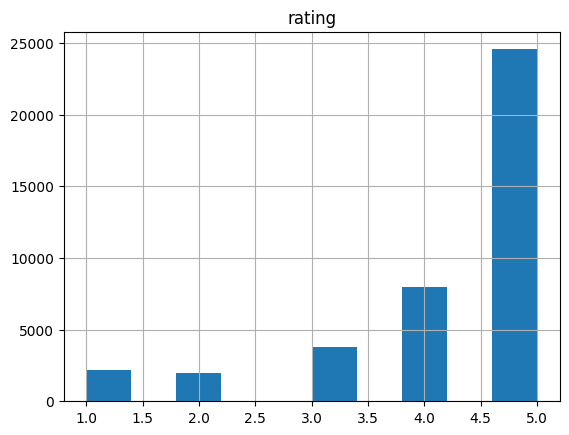

In [ ]:
df.hist('rating')

In [ ]:
# Scaler
def norm(x):
    return (x - x.min()) / (x.max() - x.min())

# def std(x):
#     return (x - x.mean()) / x.std()

df[['rating']] = df[['rating']].apply(norm)

array([[<Axes: title={'center': 'rating'}>]], dtype=object)

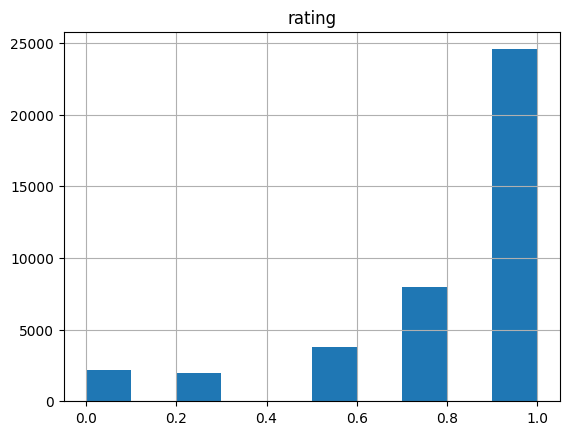

In [ ]:
df.hist('rating')

In [ ]:
# Text
def preprocessText(text:str):
  # Didn't observe significant improvement with "!?" retained in the input, auc: 0.75808 while removed auc:0.75723
  # return ''.join(filter(lambda ch: ch.isalnum() or ch.isspace() or ch in ['!', '?'], text.lower()))
  return ''.join(filter(lambda ch: ch.isalnum() or ch.isspace(), text.lower()))

df['norm_text_'] = df.apply(lambda row: preprocessText(row['text_']), axis=1)

# Word Cloud

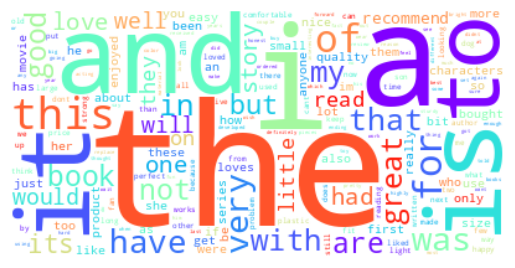

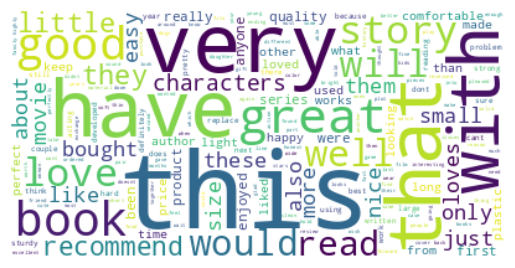

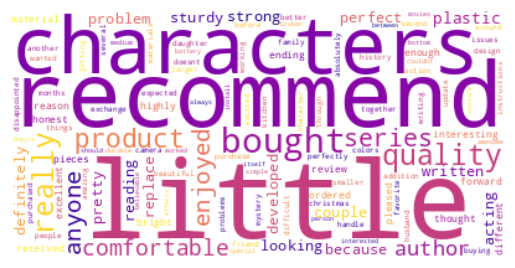

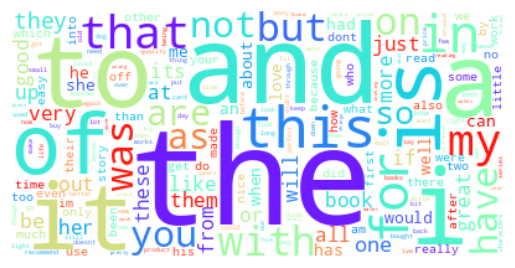

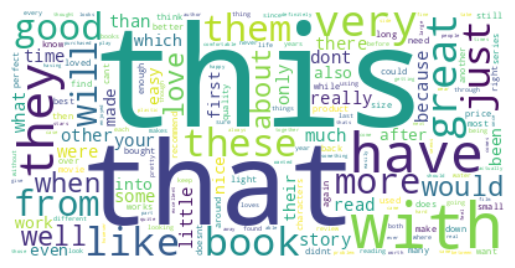

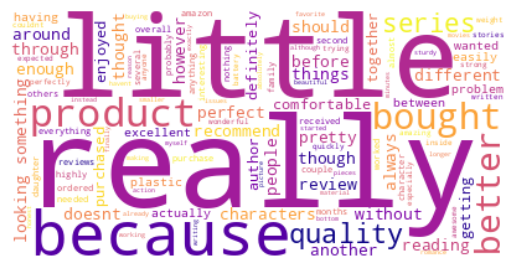

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def word_cloud(df):
  words_all = ' '.join(df)
  tokens = nltk.word_tokenize(words_all)
  tokens = [token for token in tokens if not token.isnumeric()]
  fdist = nltk.FreqDist(tokens)
  frequent_words = dict([(m, n) for m, n in fdist.items()])
  frequent_words_3 = dict([(m, n) for m, n in fdist.items() if len(m) > 3])
  frequent_words_5 = dict([(m, n) for m, n in fdist.items() if len(m) > 5])

  wcloud = WordCloud(background_color="white",
      colormap="rainbow",
      width=400, height=200).generate_from_frequencies(frequent_words)
  wcloud_3 = WordCloud(background_color="white",
      colormap="viridis",
      width=400, height=200).generate_from_frequencies(frequent_words_3)
  wcloud_5 = WordCloud(background_color="white",
      colormap="plasma",
      width=400, height=200).generate_from_frequencies(frequent_words_5)

  # Plotting the wordcloud
  plt.imshow(wcloud, interpolation="bilinear")
  plt.axis("off")
  (-0.5, 399.5, 199.5, -0.5)
  plt.show()

  plt.imshow(wcloud_3, interpolation="bilinear")
  plt.axis("off")
  (-0.5, 399.5, 199.5, -0.5)
  plt.show()

  plt.imshow(wcloud_5, interpolation="bilinear")
  plt.axis("off")
  (-0.5, 399.5, 199.5, -0.5)
  plt.show()


cg = df[df['label'] == 'CG']['norm_text_']
or_ = df[df['label'] == 'OR']['norm_text_']

word_cloud(cg)
word_cloud(or_)

In [ ]:
# Duplicate data/reviews
duplicated_reviews = df[df.duplicated(subset=['text_'], keep=False)]
df.drop_duplicates(subset=['text_'], inplace=True) # The first occurence is not included, keep is defaulted to first. false=drop all duplicates
duplicated_reviews

,category,rating,label,text_,num_sentences,norm_text_
143,Home_and_Kitchen_5,1.00,CG,Easy to put together and looks nice and the fi...,2,easy to put together and looks nice and the fi...
725,Home_and_Kitchen_5,0.75,CG,Easy to put together and looks nice and the fi...,2,easy to put together and looks nice and the fi...
4344,Sports_and_Outdoors_5,0.75,CG,It does the job but it takes a lot of practice...,2,it does the job but it takes a lot of practice...
4735,Sports_and_Outdoors_5,0.50,CG,It does the job but it takes a lot of practice...,2,it does the job but it takes a lot of practice...
6018,Sports_and_Outdoors_5,1.00,CG,"This is a really good starter kit, with lots o...",2,this is a really good starter kit with lots of...
6025,Sports_and_Outdoors_5,1.00,CG,"This is a really good starter kit, with lots o...",2,this is a really good starter kit with lots of...
6706,Sports_and_Outdoors_5,1.00,CG,"Great, no complaints. Comfortable, phone fits ...",6,great no complaints comfortable phone fits in ...
6708,Sports_and_Outdoors_5,1.00,CG,"Great, no complaints. Comfortable, phone fits ...",6,great no complaints comfortable phone fits in ...
12289,Movies_and_TV_5,1.00,CG,One of the best movies of the year. Not for e...,3,one of the best movies of the year not for ev...
12448,Movies_and_TV_5,0.50,CG,It was a good movie. I liked the movie. The pl...,3,it was a good movie i liked the movie the plot...


In [ ]:
print(len(duplicated_reviews))
df.shape
df

40


,category,rating,label,text_,num_sentences,norm_text_
0,Home_and_Kitchen_5,1.00,CG,"Love this! Well made, sturdy, and very comfor...",3,love this well made sturdy and very comfortab...
1,Home_and_Kitchen_5,1.00,CG,"love it, a great upgrade from the original. I...",2,love it a great upgrade from the original ive...
2,Home_and_Kitchen_5,1.00,CG,This pillow saved my back. I love the look and...,2,this pillow saved my back i love the look and ...
3,Home_and_Kitchen_5,0.00,CG,"Missing information on how to use it, but it i...",2,missing information on how to use it but it is...
4,Home_and_Kitchen_5,1.00,CG,Very nice set. Good quality. We have had the s...,3,very nice set good quality we have had the set...
...,...,...,...,...,...,...
40427,Clothing_Shoes_and_Jewelry_5,0.75,OR,I had read some reviews saying that this bra r...,22,i had read some reviews saying that this bra r...
40428,Clothing_Shoes_and_Jewelry_5,1.00,CG,I wasn't sure exactly what it would be. It is ...,28,i wasnt sure exactly what it would be it is a ...
40429,Clothing_Shoes_and_Jewelry_5,0.25,OR,"You can wear the hood by itself, wear it with ...",26,you can wear the hood by itself wear it with t...
40430,Clothing_Shoes_and_Jewelry_5,0.00,CG,I liked nothing about this dress. The only rea...,26,i liked nothing about this dress the only reas...


In [ ]:
# Label
df['target'] = df['label'].apply(lambda a: 0 if a=='CG' else 1)
df['target']

,target
0,0
1,0
2,0
3,0
4,0
...,...
40427,1
40428,0
40429,1
40430,0


In [ ]:
# Decided not to do stopwords elimination for different pattern in CG/OR

In [ ]:
# Category
# One-hot encode the categories
onehot_encoder = OneHotEncoder(sparse_output=False)
category_onehot = onehot_encoder.fit_transform(df['category'].values.reshape(-1, 1))
category_onehot_df = pd.DataFrame(category_onehot, columns=onehot_encoder.get_feature_names_out(), index=df.index)
df_with_onehot = pd.concat([df.drop('category', axis=1), category_onehot_df], axis=1)

In [ ]:
df_with_onehot

,rating,label,text_,num_sentences,norm_text_,target,x0_Books_5,x0_Clothing_Shoes_and_Jewelry_5,x0_Electronics_5,x0_Home_and_Kitchen_5,x0_Kindle_Store_5,x0_Movies_and_TV_5,x0_Pet_Supplies_5,x0_Sports_and_Outdoors_5,x0_Tools_and_Home_Improvement_5,x0_Toys_and_Games_5
0,1.00,CG,"Love this! Well made, sturdy, and very comfor...",3,love this well made sturdy and very comfortab...,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.00,CG,"love it, a great upgrade from the original. I...",2,love it a great upgrade from the original ive...,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.00,CG,This pillow saved my back. I love the look and...,2,this pillow saved my back i love the look and ...,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.00,CG,"Missing information on how to use it, but it i...",2,missing information on how to use it but it is...,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.00,CG,Very nice set. Good quality. We have had the s...,3,very nice set good quality we have had the set...,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40427,0.75,OR,I had read some reviews saying that this bra r...,22,i had read some reviews saying that this bra r...,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40428,1.00,CG,I wasn't sure exactly what it would be. It is ...,28,i wasnt sure exactly what it would be it is a ...,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40429,0.25,OR,"You can wear the hood by itself, wear it with ...",26,you can wear the hood by itself wear it with t...,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40430,0.00,CG,I liked nothing about this dress. The only rea...,26,i liked nothing about this dress the only reas...,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df_with_onehot['num_characters'] = df_with_onehot['norm_text_'].apply(len) # space included
df_with_onehot['num_words'] = df_with_onehot['norm_text_'].apply(lambda x: len(nltk.word_tokenize(x)))

In [ ]:
df = df_with_onehot
df

,rating,label,text_,num_sentences,norm_text_,target,x0_Books_5,x0_Clothing_Shoes_and_Jewelry_5,x0_Electronics_5,x0_Home_and_Kitchen_5,x0_Kindle_Store_5,x0_Movies_and_TV_5,x0_Pet_Supplies_5,x0_Sports_and_Outdoors_5,x0_Tools_and_Home_Improvement_5,x0_Toys_and_Games_5,num_characters,num_words
0,1.00,CG,"Love this! Well made, sturdy, and very comfor...",3,love this well made sturdy and very comfortab...,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,70,12
1,1.00,CG,"love it, a great upgrade from the original. I...",2,love it a great upgrade from the original ive...,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,77,16
2,1.00,CG,This pillow saved my back. I love the look and...,2,this pillow saved my back i love the look and ...,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,65,14
3,0.00,CG,"Missing information on how to use it, but it i...",2,missing information on how to use it but it is...,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,79,17
4,1.00,CG,Very nice set. Good quality. We have had the s...,3,very nice set good quality we have had the set...,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,83,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40427,0.75,OR,I had read some reviews saying that this bra r...,22,i had read some reviews saying that this bra r...,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1642,329
40428,1.00,CG,I wasn't sure exactly what it would be. It is ...,28,i wasnt sure exactly what it would be it is a ...,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1260,270
40429,0.25,OR,"You can wear the hood by itself, wear it with ...",26,you can wear the hood by itself wear it with t...,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1896,340
40430,0.00,CG,I liked nothing about this dress. The only rea...,26,i liked nothing about this dress the only reas...,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1246,278


## Model Training

In [ ]:
# Vectorizarion TF-IDF
tfidf = TfidfVectorizer(max_features=3000)
X_tfidf = tfidf.fit_transform(df['norm_text_'])

X = hstack([X_tfidf, csr_matrix(df.drop(['label', 'text_', 'norm_text_', 'target'], axis=1).values)])
y = df['target']

In [ ]:
print(X_tfidf.toarray()[0])
print(X_tfidf[0])
X_tfidf.shape
# print(X_tfidf)  # view sparse matrix in COO format

[0. 0. 0. ... 0. 0. 0.]
  (0, 1570)	0.4341777994375571
  (0, 2648)	0.12523225883895564
  (0, 2879)	0.2201607480039436
  (0, 1585)	0.2889593690179653
  (0, 2529)	0.3503975985582345
  (0, 137)	0.10517904472615403
  (0, 2813)	0.1820066411491394
  (0, 549)	0.31600529430531654
  (0, 1409)	0.5401696774186885
  (0, 2001)	0.324388803040212


(40412, 3000)

In [ ]:
def k_fold_cross_validation(model, kf, X, y, model_name, feature_selector = None, selected_features = [True] * 3014):
    """
    @Author YJ
    Perform k-fold cross-validation, record rmse_scores, mae_scores, r2_scores, actual_values, predicted_values, residuals
    to facilitate evaluation and visualization.

    Parameters:
    model: model to train
    kf: KFold validation
    X: feature values
    y: target values
    feature_selector(RFE Model): default to None, use the selector to select features
    selected_feature: Boolean mask of selected features(feature_selector.support_), default to All True
    """
    # Initialize lists to store metrics
    rmse_scores = []
    mae_scores = []
    r2_scores = []
    # Initialize lists to store actual & predicted value
    actual_values = []
    predicted_values = []
    residuals = []

    for train_index, test_index in kf.split(X):
        # X_train, X_test = X.iloc[train_index].loc[:, selected_features], X.iloc[test_index].loc[:, selected_features]
        # y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        X_train, X_test = X[train_index, :], X[test_index, :]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Train the model
        model.fit(X_train, y_train)

        # Make predictions
        y_pred = model.predict(X_test)

        # Train RFE model
        if(feature_selector):
            feature_selector.fit(X_train, y_train)

        # Calculate evaluation metrics
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        # Append scores to lists
        rmse_scores.append(rmse)
        mae_scores.append(mae)
        r2_scores.append(r2)

        # Store the actual and predicted values
        actual_values.extend(y_test)
        predicted_values.extend(y_pred)

        # Calculate residuals
        residuals.extend(y_test - y_pred)

        # Print metrics for each fold
        # cm = confusion_matrix(y_test, y_pred)
        print(classification_report(y_test, model.predict(X_test)))
        print('Training set score: {:.4f}'.format(model.score(X_train, y_train)))
        print('Test set score: {:.4f}'.format(model.score(X_test, y_test)))

        # Visualization
    visualize_results(model, X_test, y_test, model.predict(X_test), tfidf, model_name)
    return rmse_scores, mae_scores, r2_scores, actual_values, predicted_values, residuals

In [ ]:
def print_average_metrics(rmse_scores, mae_scores, r2_scores):
    """
    Take rmse_scores, mae_scores, r2_scores, calculate and print out average scores
    """
    # Calculate average scores
    avg_rmse = np.mean(rmse_scores)
    avg_mae = np.mean(mae_scores)
    avg_r2 = np.mean(r2_scores)
    # Print average scores
    print("Average RMSE:", avg_rmse)
    print("Average MAE:", avg_mae)
    print("Average R^2:", avg_r2)

Results - Decision Tree
              precision    recall  f1-score   support

           0       0.76      0.76      0.76      4036
           1       0.76      0.76      0.76      4047

    accuracy                           0.76      8083
   macro avg       0.76      0.76      0.76      8083
weighted avg       0.76      0.76      0.76      8083

Training set score: 1.0000
Test set score: 0.7574
              precision    recall  f1-score   support

           0       0.77      0.76      0.77      4147
           1       0.75      0.76      0.76      3936

    accuracy                           0.76      8083
   macro avg       0.76      0.76      0.76      8083
weighted avg       0.76      0.76      0.76      8083

Training set score: 1.0000
Test set score: 0.7615
              precision    recall  f1-score   support

           0       0.76      0.77      0.76      4009
           1       0.77      0.75      0.76      4073

    accuracy                           0.76      8082
   m

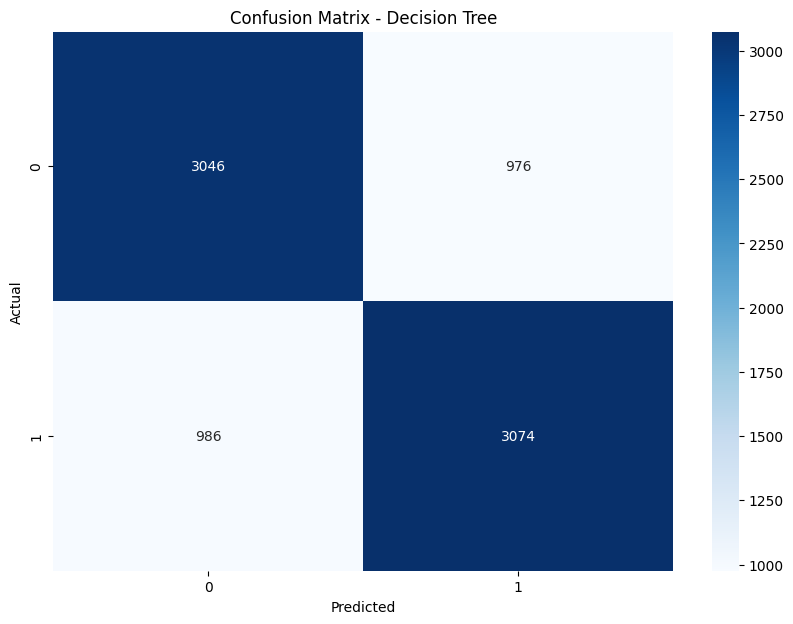

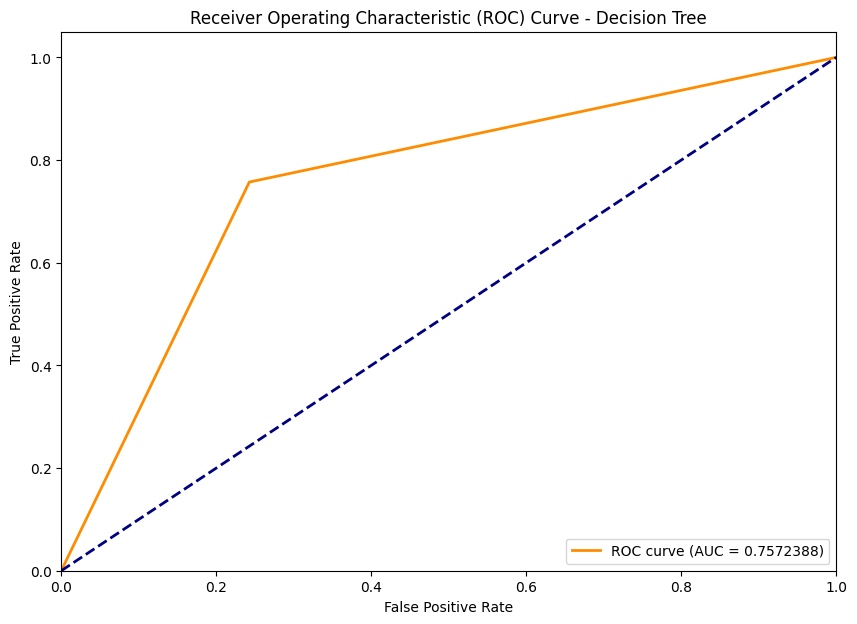

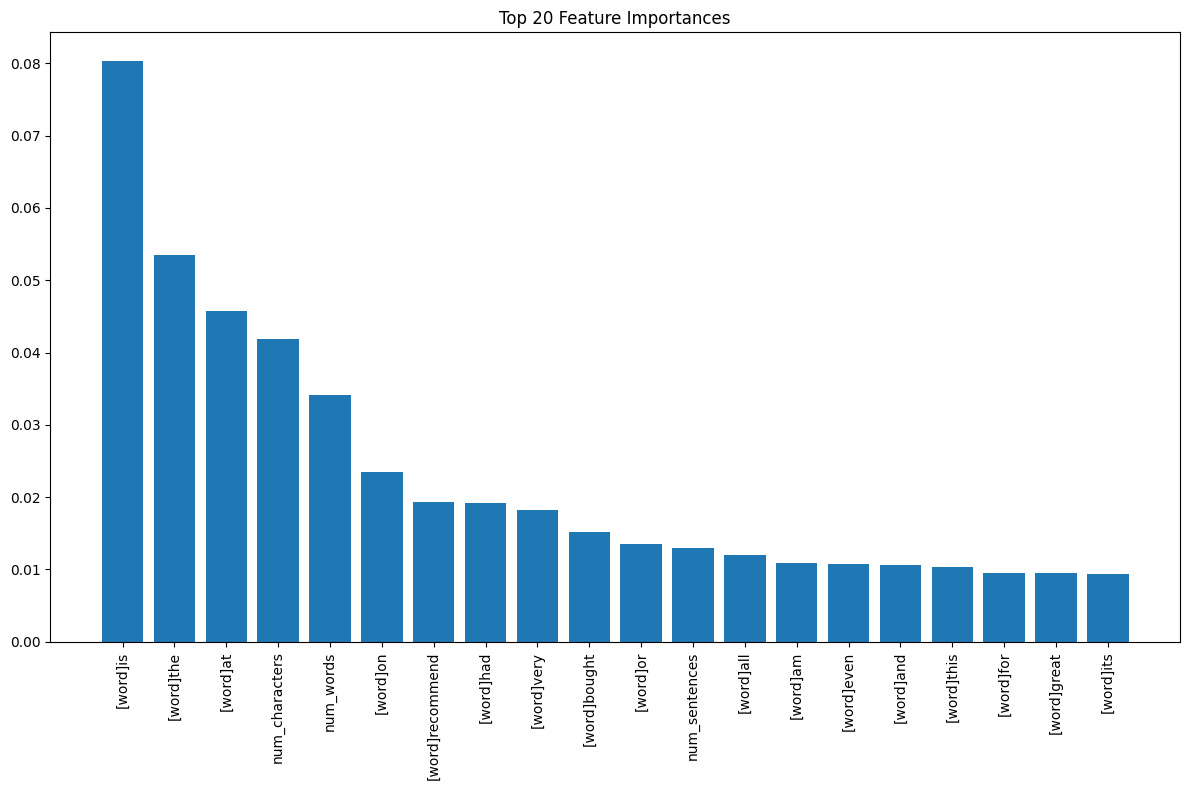

Average RMSE: 0.491079555949778
Average MAE: 0.2411660199643007
Average R^2: 0.035148962508962864


In [ ]:
# Initialize k-fold cross-validation, 5-fold to ensure we have an 80:20 split
kf = KFold(n_splits=5, shuffle=True, random_state=42)
dt_clf = DecisionTreeClassifier()
# Store metrics in results
print("Results - Decision Tree")
results = k_fold_cross_validation(dt_clf, kf, X, y, "Decision Tree")
# Unpack results[0:3] and pass them to the function
print_average_metrics(*results[0:3])

Results - Random Forest Tree
              precision    recall  f1-score   support

           0       0.87      0.90      0.89      4036
           1       0.90      0.87      0.88      4047

    accuracy                           0.88      8083
   macro avg       0.89      0.88      0.88      8083
weighted avg       0.89      0.88      0.88      8083

Training set score: 0.9999
Test set score: 0.8847
              precision    recall  f1-score   support

           0       0.88      0.89      0.88      4147
           1       0.88      0.87      0.88      3936

    accuracy                           0.88      8083
   macro avg       0.88      0.88      0.88      8083
weighted avg       0.88      0.88      0.88      8083

Training set score: 1.0000
Test set score: 0.8812
              precision    recall  f1-score   support

           0       0.88      0.89      0.89      4009
           1       0.89      0.88      0.89      4073

    accuracy                           0.89      8082

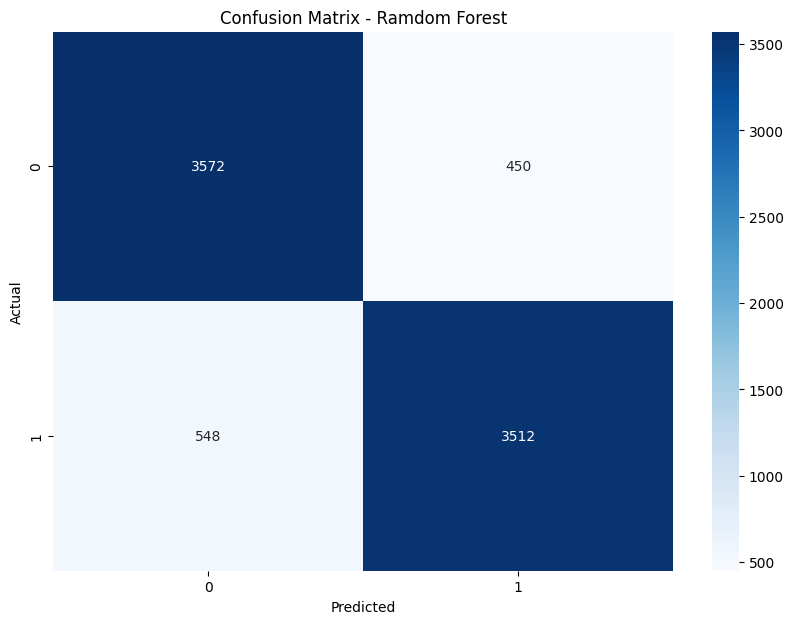

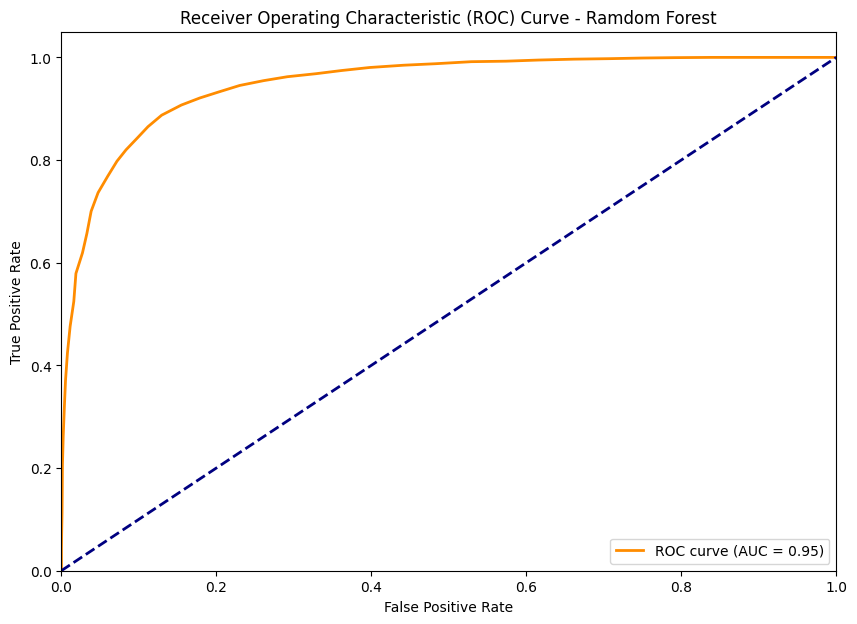

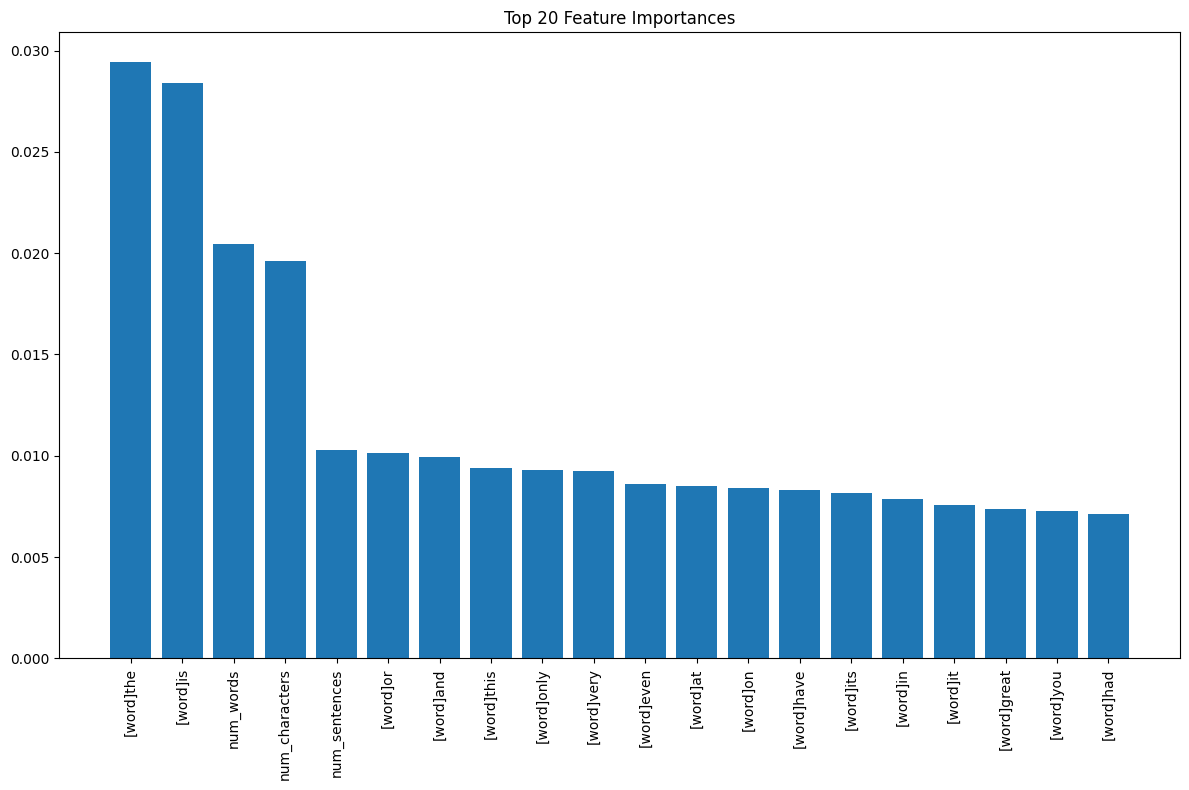

Average RMSE: 0.34313084635428864
Average MAE: 0.11776208682236815
Average R^2: 0.5288594419814412


In [ ]:
# Initialize k-fold cross-validation, 5-fold to ensure we have an 80:20 split
kf = KFold(n_splits=5, shuffle=True, random_state=42)
rft_clf = RandomForestClassifier(n_estimators=50, random_state=42)
# Store metrics in results
print("Results - Random Forest Tree")
results = k_fold_cross_validation(rft_clf, kf, X, y, "Ramdom Forest")
# Unpack results[0:3] and pass them to the function
print_average_metrics(*results[0:3])